###   Basic configuration steps

We import some standard packages to do this task. In addition, some bespoke functions have been created to help serve other purposes, mostly pertaining to charting in Plotly.

**For this Jupyter Notebook, all graphics are static because of the challenge in rendering interactive graphics in Github**

In [8]:
#- import basic python packages
import warnings
import tkinter # to show plot in Pycharm

#- import packages for data manipulations
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, RobustScaler
from imblearn.over_sampling import SMOTE

#- import packages for unsupervised machine learning
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA, SparsePCA
from sklearn.manifold import TSNE

#- import packages for supervised machine learning
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.feature_selection import RFE

#- import packages for model evaluation
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_curve, roc_curve, recall_score, precision_score, average_precision_score
from sklearn.metrics import auc, roc_auc_score, classification_report

#- import packages for visualizations
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.tools import FigureFactory as FF
import plotly.io as pio
pio.renderers.default = "svg"

#- packages created
from utils import corr_heatmap, tsne_plotting, pca_plotting
from utils import model_scores, multiple_roc_curves, create_scores_df, create_prec_recall_df, precision_recall


#- configuration steps
warnings.simplefilter(action='ignore', category = FutureWarning)
palette = sns.color_palette("PiYG_r")
sns.set_palette("Set3")

### Reading in the relevant CSV file

We read in the relevant CSV file. We observe that the dataset is highly dimensional. We note that all the features of the data have already been PCA-transformed except 'time' and 'amount'. Since all features need to be scaled before PCA is implemented, we can assume that all 'V' features are scaled.

In [9]:
credit_df = pd.read_csv('creditcard.csv')
print("We look at a sample of the data: \n", credit_df.head())

#- let us scale the 'time' and 'amount' features using 'RobustScaler' which is less susceptible to outliers
#- RobustScaler removes the median and scales the data according to the IQR (i.e. between 1st quartile and 3rd quartile)
robust_scaler = RobustScaler()
credit_df["robustscaled_time"] = robust_scaler.fit_transform(credit_df["Time"].values.reshape(-1,1))
credit_df["robustscaled_amount"] = robust_scaler.fit_transform(credit_df["Amount"].values.reshape(-1,1))
credit_df.head()

#- we drop some of the columns
cols_to_drop = ["Time", "Amount", "robustscaled_time"]
X = credit_df.drop(cols_to_drop + ["Class"], axis = 1)
y = credit_df.loc[:,"Class"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
print("Shape of the X_train dataset: ", X_train.shape)
print("Shape of the y_train dataset: ", y_train.shape)

We look at a sample of the data: 
    Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010  

### Examine balance of class in dataset

We attempt to plot a simple bar graph to examine the balance of class. It can be seen that the minority class (blue bar) is almost nowhere to be seen vis-a-vis the majority class (orange bar).

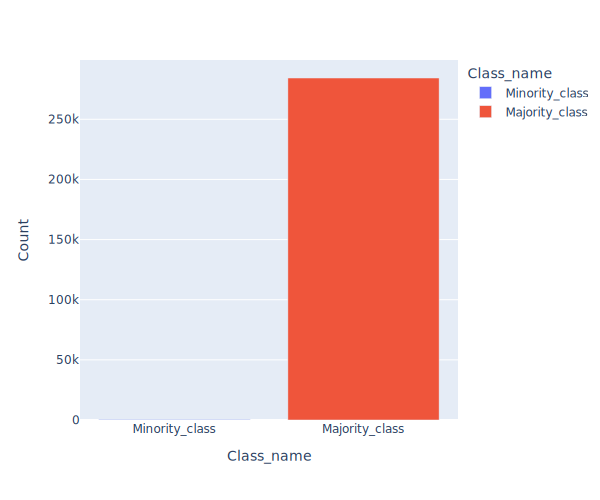

In [10]:
#- plot a simple bar graph
class_counts_df = pd.DataFrame(credit_df.Class.value_counts()).sort_values(by = "Class").reset_index(drop = True)
class_counts_df["Class_name"] = ["Minority_class","Majority_class"]
class_counts_df.columns = ["Count", "Class_name"]

#- plot the graphs
fig1 = px.bar(class_counts_df, x = "Class_name", y = "Count", color = "Class_name", width = 600)
fig1.show()

We do a check on the actual data count.

In [11]:
#- do a check on the actual counts
prop_result = class_counts_df.Count.min() / class_counts_df.Count.sum()
print("Minority class proportion: " + str(prop_result) + "%")
if prop_result < 1:
    print("We are dealing with a highly unbalanced dataset")
else:
    print("The dataset is not highly unbalanced")

Minority class proportion: 0.001727485630620034%
We are dealing with a highly unbalanced dataset


### Application of the SMOTE technique to over-sample the minority class

We attempt to apply the SMOTE technique to bump up the number of minority class. 

**NOTE1**: we apply SMOTE first, then apply train_test_split; apply SMOTE on training data only

**NOTE2**: we apply SMOTE first, then execute cross-validation later

We will see that post-application of SMOTE, the minority and majority class becomes balanced.

In [12]:
#- we have an unbalanced training dataset
print("Before OverSampling, counts of label 'Minority class' in training dataset: {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label 'Majority class' in training dataset: {} \n".format(sum(y_train == 0)))


#- we now implement the SMOTE technique
#- note that we need to ensure that "y_train" is continuous; so we use the "ravel" method to do that
smote = SMOTE(random_state = 88)
X_train_oversample, y_train_oversample = smote.fit_resample(X_train, y_train.ravel())

#- we now have a balanced training dataset
print("After OverSampling, counts of label 'Minority class' in training dataset: {}".format(sum(y_train_oversample == 1)))
print("After OverSampling, counts of label 'Majority class' in training dataset: {} \n".format(sum(y_train_oversample == 0)))

Before OverSampling, counts of label 'Minority class' in training dataset: 391
Before OverSampling, counts of label 'Majority class' in training dataset: 227454 

After OverSampling, counts of label 'Minority class' in training dataset: 227454
After OverSampling, counts of label 'Majority class' in training dataset: 227454 



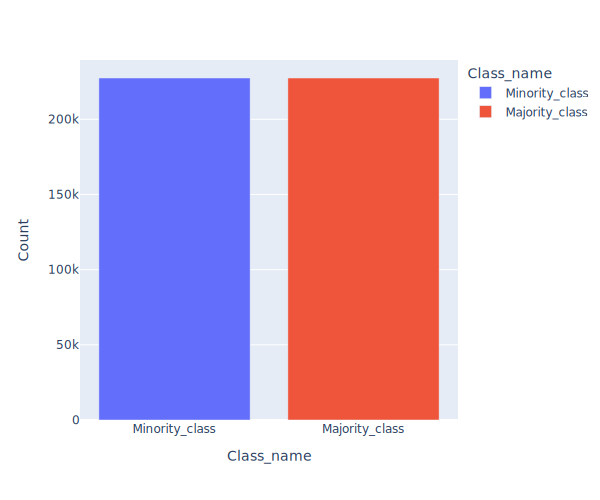

In [13]:
#- we check out the new counts plot
y_train_oversample_df = pd.DataFrame(pd.DataFrame(y_train_oversample).value_counts()).reset_index(drop = True).sort_values(by = 0)
y_train_oversample_df["Class_name"] = ["Minority_class","Majority_class"]
y_train_oversample_df.columns = ["Count", "Class_name"]

#- plot the graphs
fig2 = px.bar(y_train_oversample_df, x="Class_name", y="Count", color = "Class_name", width = 600)
fig2.show()

We attempt to plot the correlation plots on the oversampled training data to see the relationship between the features.

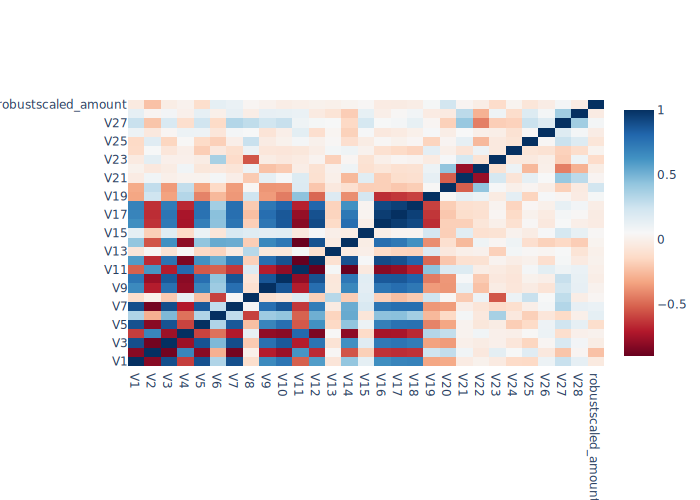

In [14]:
#- plot correlation plots on the oversampled training data
corr_heatmap(X_train_oversample)

###   Unsupervised machine learning / clustering --- employ clustering methods: KMeans, DBSCAN

Having seen the correlation between features, we wonder if we could perform some unsupervised learning to separate out the fraud and non-fraud cases. Prior to that, we do a sampling plot to observe the interaction between selected sample features.

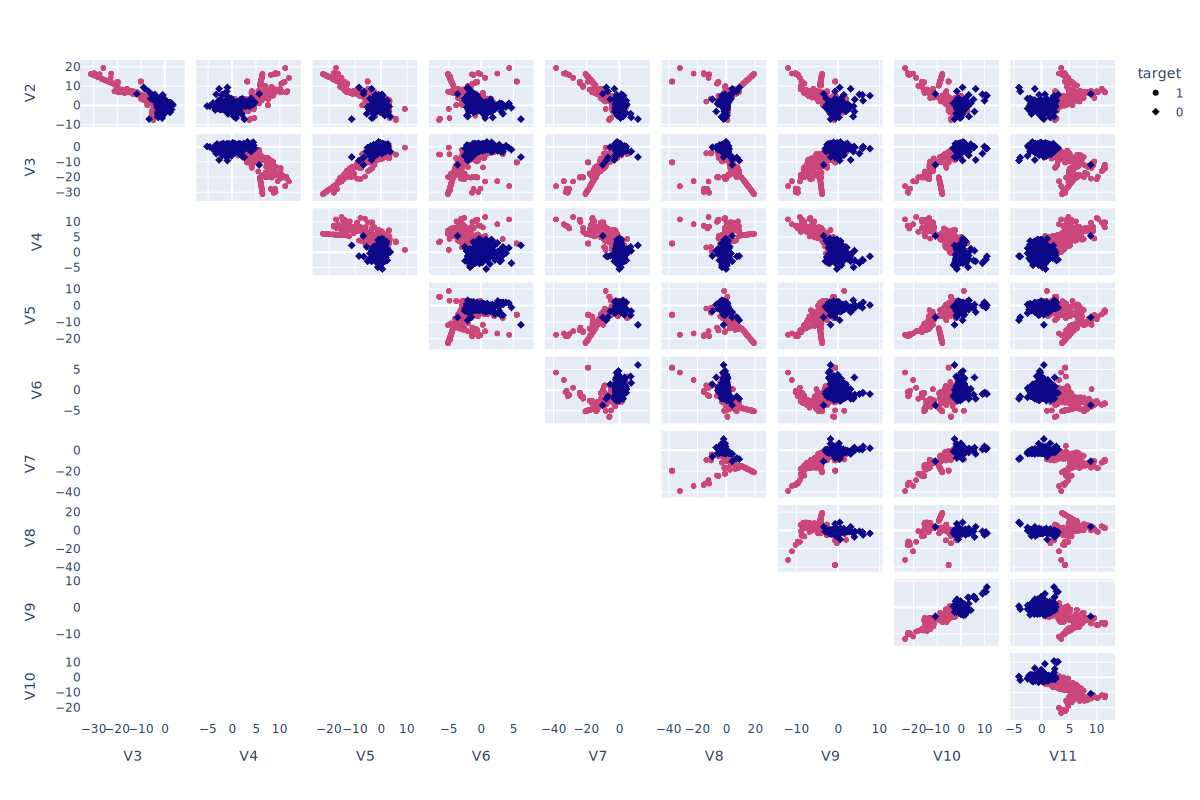

In [17]:
#=== we plot the scatter plot and look at the interaction of the features (subset of data shown)

#- select random four groups of 1000 samples to do clustering
y_df = pd.DataFrame(y_train_oversample).rename({0: 'target'}, axis = 1)
X_df = pd.DataFrame(X_train_oversample)

#- sample group 1
y_sample1 = y_df.sample(n = 1000, random_state = 0)
X_sample1 = X_df.iloc[y_sample1.index]
sample_df = pd.concat([X_sample1, y_sample1], axis = 1) # a well-balanced sample data

#- we plot the scatter plot matrix for selected features; we see pretty good separation of values
fig4 = px.scatter_matrix(sample_df,
                         dimensions=list(sample_df.iloc[:, 1:11].columns),
                         color="target", symbol="target", width = 1200, height = 800)

fig4.update_traces(diagonal_visible = False)
fig4.update_traces(showlowerhalf = False)
fig4.update_coloraxes(showscale = False)
fig4.show()

**We now attempt to perform clustering**. We will explore two clustering techniques here (KMeans clustering and DBSCAN clustering) to see if we can clearly identify some clusters. 

But first use the **KMeans** clustering technique. KMeans uses the 'k-means++' algorithm. k-means++ is a smart centroid initialization technique algo for choosing seeds for k-means clustering algorithm. KMeans takes exponential time to solve and hence suffers from the curse of dimensionality. KMeans also does not handle highly imbalanced data well; fair poorly at identifying structure in small minority class. Majority class will form large clusters and will skew all centroids nearer to it.

We will employ the elbow method to identify the optimal number of clusters to use

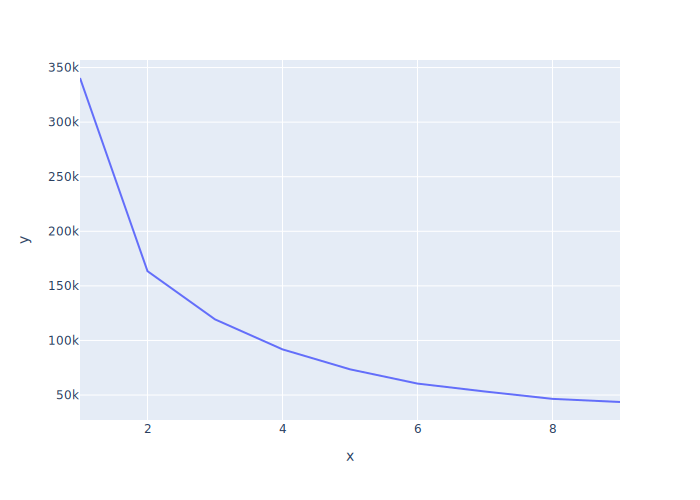

In [18]:
#--- we try using KMeans clustering

seed = 0
wcss = []
cluster_range = range(1,10)
for i in cluster_range:
    kmeans1 = KMeans(n_clusters = i, init = 'k-means++', random_state = seed)
    kmeans1.fit(sample_df)  # we fit a sample subset, oversampled data
    wcss.append(kmeans1.inertia_)

kmeans_df = pd.DataFrame({'x':list(cluster_range), 'y':wcss})

fig5 = px.line(kmeans_df, x = 'x', y = 'y')
fig5.show()  # using elbow method we see that the optimal number of cluster is 4 (using oversampled data)

Judging from the elbow plot, we note that the optimal number of clusters should be **2**.

In [19]:
#--- fit and transform based on the cluster number and create dataframe with clusterID results
kmeans_mb = MiniBatchKMeans(n_clusters = 2, random_state = seed).fit(sample_df)
X_clusters_kmeans = kmeans_mb.predict(sample_df)  # do a prediction using oversampled data
sample_cluster_kmeans_df = sample_df.copy()
sample_cluster_kmeans_df["ClustID"] = list(X_clusters_kmeans)

Next, we apply the **DBSCAN** (Density-Based Spatial Clustering of Applications with Noise) clustering.

DBSCAN is a Density-Based clustering algorithm and considers distance between nearest points. It reduces the problem of KMeans where a slight change in data points might affect the clustering outcome. Unlike DBSCAN, Kmeans cannot handle "odd-shaped data", and the number of clusters need to be specified (hard to know what "k" to use).

For DBSCAN, the number of clusters need not be specified; all we need is a function to calculate distance between values and some guidance for what amount of distance is considered "close". DBSCAN produces more reasonable results than KMeans across a variety of different distributions. The following are some of the DBSCAN parameters:
- "minPts" (min no. of points clustered for a region to be taken as dense; at least 3 / 2 x dim)
- "eps" (a distance measure used to locate the points in the neighbourhood of any point)


In DBSCAN, noisy samples are given the label "-1". We should be aware that DBSCAN does not seem to work well in cases where the points are mostly individually far apart from each other (hence eps cannot be maintained at small values) such that we either end up having many clusters, or a lot of noisy samples).

In [20]:
X_clusters_dbscan = DBSCAN(eps = 0.3, min_samples = 3).fit_predict(sample_df) # we are taking an unusually large eps
# print(set(X_clusters_dbscan)) # "min_samples" of 3 returns 3 clusters; anything more returns 1 cluster with noise
sample_cluster_dbscan_df = sample_df.copy()
sample_cluster_dbscan_df["ClustID"] = list(X_clusters_dbscan)
print(sample_cluster_dbscan_df.ClustID.value_counts())

-1    980
 0     10
 1      4
 3      3
 2      3
Name: ClustID, dtype: int64


### Using dimensionality reduction algorithms we do some plots to see how the separation of clusters is like


We start by using **Principle Component Analysis ("PCA")** clustering and we plot the 3D scatter plot (three principal components) of the result (colouring the "dots" by clusterID) using the PCA technique. Since the data itself has already been processed by PCA, the explained variance amongst all the features are quite distributed. And also, since we want to do viz, we take "n_components" to be 3.

For future application, we can create a new dataframe to add in the values of the PCA components to determine the clusters of new data, we just need to fit and transform the data into PCA components then determine the cluster number.

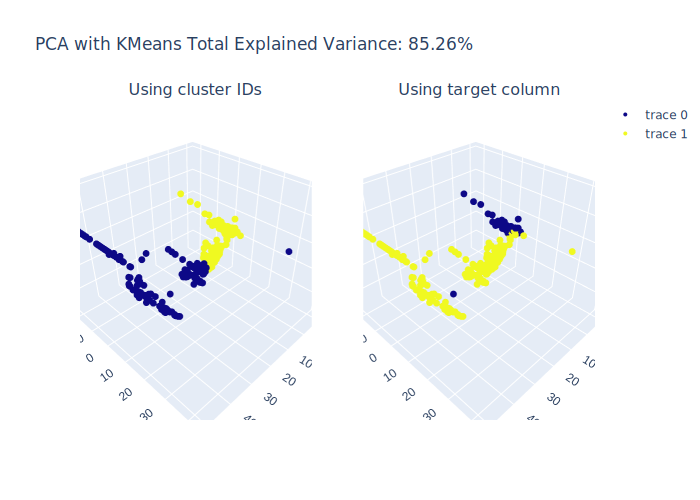

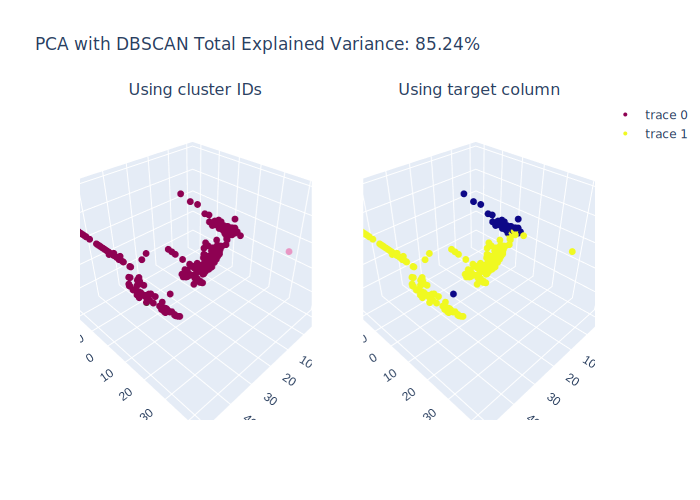

In [21]:
pca_plotting(sample_cluster_kmeans_df, "ClustID", "KMeans")
pca_plotting(sample_cluster_dbscan_df, "ClustID", "DBSCAN")

We next perform dimensionality reduction using **t-Distributed Stochastic Neighbour Embedding ("t-SNE")**. t-SNE is a tool to visualize high-dimensional data converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between joint probabilities of the low-dimensional embedding and the high-dimensional data. 

It is highly recommended to use another dimensionality reduction method (e.g. PCA for dense data or TruncatedSVD for sparse data) to reduce dimensionality to a reasonable amount (e.g. 50) if the number of features is very high; in order to suppress some noise and speed up the computation of pairwise distances between samples.

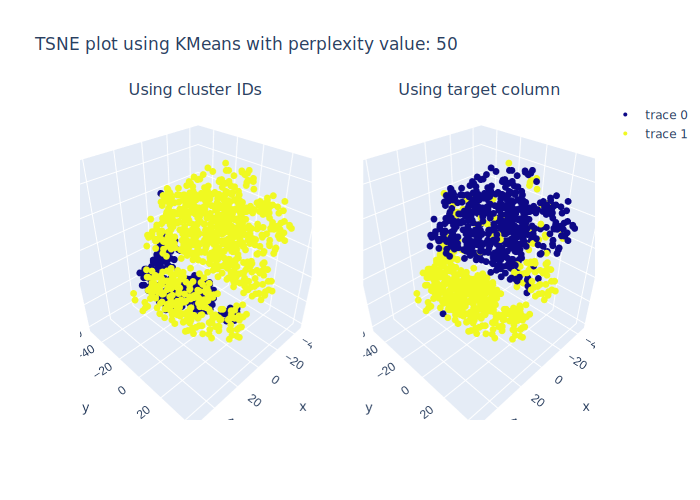

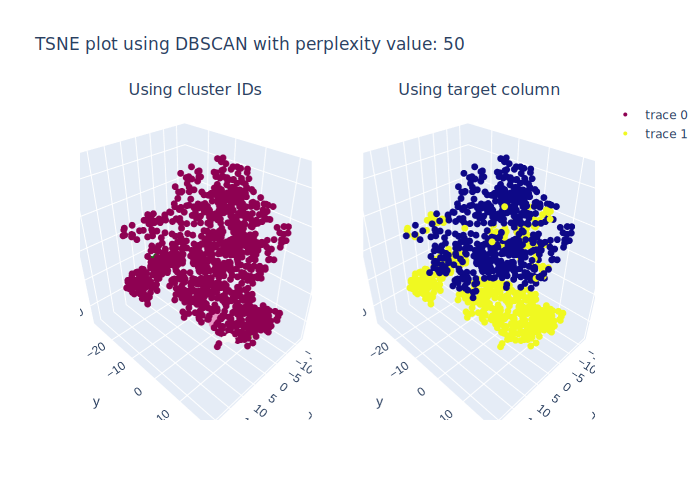

In [23]:
# tsne_plotting(sample_cluster_kmeans_df, "ClustID", 13, "KMeans")
tsne_plotting(sample_cluster_kmeans_df, "ClustID", 50, "KMeans")
tsne_plotting(sample_cluster_dbscan_df, "ClustID", 50, "DBSCAN")

###   Supervised machine learning --- employ techniques: Logistic regression, Random Forest classifier, LightGBM

We now use supervised machine learning to help us identify fraudulent transactions. We will subsequently provide model evaluation for the models used.

### Logistic Regression (with grid search cross-validation)

**Logistic regression** is a Machine Learning algorithm that is used to predict the probability of a categorical dependent variable. The dependent variable is a binary variable that contains data coded as "1" or "0". We use **'GridSearchCV'** implements a 'fit' and 'score' method parameters of the estimator are optimized by cross-validated grid-search over a parameter grid.

In [24]:
#- run a grid search for the best parameter
logreg = LogisticRegression()
logreg_params = {'C' : [2.5, 3, 3.5, 4, 4.5], 'max_iter' : [200]}
logreg_clf = GridSearchCV(estimator = logreg, param_grid = logreg_params, cv = 5, verbose = 5, n_jobs = 3)
logreg_clf.fit(X_train_oversample, y_train_oversample)
chosen_logreg_param = logreg_clf.best_params_['C']

#- use the best parameter to call the logistic regression model
logreg_best_clf = LogisticRegression(C = 3, max_iter = 200)\
                                    .fit(X_train_oversample, y_train_oversample)

logreg_pred, logreg_pred_proba, fpr_logreg, tpr_logreg, prec_logreg, recall_logreg, avg_prec_logreg = \
                                                                        model_scores(logreg_best_clf, X_test, y_test)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


### Random Forest (with grid search cross-validation)

**Random Forest** is less affected by noise and generalizes better, reducing variance (generalization error reaches a limit with an increasing number of trees being grown (based on Central Limit Theorem). Random Forest is immune against over-fitting (as number of trees increases) as long as its weak classifiers do not over-fit to the data. The following are some of the parameters that can be tuned:
- n_estimators: number of trees in the forest
- max_features: max number of features considered for splitting a node
- max_depth: max number of levels in each decision tree
- min_samples_split: min number of data points placed in a node before the node is split

In [25]:
#- run a grid search for the best parameter
rf = RandomForestClassifier()
rf_params = {'n_estimators' : [150, 200], 'max_depth' : [10, 20], 'min_samples_split' : [5]}
rf_clf = GridSearchCV(estimator = rf, param_grid = rf_params, cv = 5, verbose = 5, n_jobs = 3)
rf_clf.fit(X_train_oversample, y_train_oversample)
chosen_rf_param = rf_clf.best_params_

#- use the best parameter to call the random forest model (optimal n_estimators is 200)
rf_best_clf = RandomForestClassifier(n_estimators = 200, max_depth = 20, min_samples_split = 5)\
                                    .fit(X_train_oversample, y_train_oversample)

rf_pred, rf_pred_proba, fpr_rf, tpr_rf, prec_rf, recall_rf, avg_prec_rf = model_scores(rf_best_clf, X_test, y_test)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END ...............C=2.5, max_iter=200;, score=0.944 total time=  12.4s
[CV 4/5] END ...............C=2.5, max_iter=200;, score=0.943 total time=  11.9s
[CV 3/5] END .................C=3, max_iter=200;, score=0.943 total time=  12.1s
[CV 2/5] END ...............C=3.5, max_iter=200;, score=0.942 total time=  10.7s
[CV 5/5] END ...............C=3.5, max_iter=200;, score=0.943 total time=  13.6s
[CV 3/5] END .................C=4, max_iter=200;, score=0.943 total time=  13.5s
[CV 1/5] END ...............C=4.5, max_iter=200;, score=0.944 total time=  11.0s
[CV 4/5] END ...............C=4.5, max_iter=200;, score=0.943 total time=  11.8s
[CV 2/5] END max_depth=10, min_samples_split=5, n_estimators=150;, score=0.989 total time= 7.0min
[CV 1/5] END max_depth=10, min_samples_split=5, n_estimators=200;, score=0.991 total time= 9.3min
[CV 4/5] END max_depth=10, min_samples_split=5, n_estimators=200;, score=0.990 total time= 9.2mi

### LightGBM (with grid search cross-validation)


Gradient boosting is a machine learning technique that produces a prediction model in the form of an ensemble of weak classifiers, optimizing a differentiable loss function. Boosted Decision Trees is a popular type of gradient boosting that is internally made of ensemble of weak decision trees.

There are two different strategies to compute trees:
1. level-wise / depth-wise: tree grows level by level, each node splits the data prioritizing nodes closer to tree root
2. leaf-wise: tree grows by splitting the data at the nodes with the highest loss change; tends to over-fit for small datasets but excels in large datasets
                   
LightGBM uses the leaf-wise (best-first) tree growth algorithm as compared with depth-wise tree growth. Leaf-wise algorithm can converge much faster, but prone to over-fitting if not used with the appropriate parameters. A leaf-wise tree is typically much deeper than a depth-wise tree.

LightGBM has lower training time than XGBoost and XGBoost hist. To get good results using a leaf-wise tree, the following are some important parameters:
1. num_leaves: main parameter to control the complexity of the tree model; set it < 2^(max_depth)
2. max_depth: to limit the tree depth explicitly
3. min_data_in_leaf: important parameter to prevent over-fitting in a leaf-wise tree. Its optimal value depends on the number of training samples and num_leaves; setting it to a large value can avoid growing too deep a tree but may cause under-fitting. In practice, setting it to 100s or 1000s is enough for a large dataset

To speed up training (may hurt training accuracy), one can consider some of the following techniques:
1. decreasing 'max_depth'; and/or
2. decreasing 'num_leaves' and/or
3. increasing 'min_gain_to_split', and/or
4. increasing 'min_data_in_leaf' / 'min_sum_hessian_in_leaf'.

In [26]:
#- run a grid search for the best parameter
lgbm = LGBMClassifier()
lgbm_params = {'max_depth' : [7, 8], 'num_leaves' : [2**7 - 1, 2**8 - 1], 'min_data_in_leaf' : [80, 100]}
lgbm_clf = GridSearchCV(estimator = lgbm, param_grid = lgbm_params, cv = 5, verbose = 5, n_jobs = 3)
lgbm_clf.fit(X_train_oversample, y_train_oversample)
chosen_lgbm_param = lgbm_clf.best_params_

#- use the best parameter to call the random forest model
lgbm_best_clf = LGBMClassifier(max_depth = 8, min_data_in_leaf = 80, num_leaves = 2**7 - 1)\
                                    .fit(X_train_oversample, y_train_oversample)

lgbm_pred, lgbm_pred_proba, fpr_lgbm, tpr_lgbm, prec_lgbm, recall_lgbm, avg_prec_lgbm = \
                                                                            model_scores(lgbm_best_clf, X_test, y_test)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[CV 1/5] END max_depth=7, min_data_in_leaf=80, num_leaves=127;, score=0.999 total time=   8.8s
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[CV 4/5] END max_depth=7, min_data_in_leaf=80, num_leaves=127;, score=0.999 total time=  10.6s
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[CV 3/5] END max_depth=7, min_data_in_leaf=80, num_leaves=255;, score=0.999 total time=  11.9s
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[CV 5/5] END max_depth=7, min_data_in_leaf=80

### Model evaluation of the supervised machine learning algorithms

We try to evaluate the supervised machine learning models using ROC and AUC

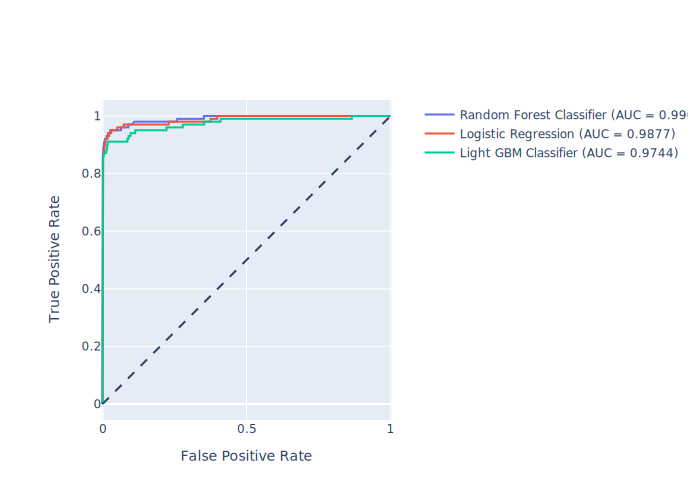

In [27]:
#- create data frame with the accuracy scores
fpr_tpr_df = pd.concat([create_scores_df(fpr_logreg, tpr_logreg, "Logistic Regression"),
                        create_scores_df(fpr_rf, tpr_rf, "Random Forest Classifier"),
                        create_scores_df(fpr_lgbm, tpr_lgbm, "Light GBM Classifier")])

#- plot the curve for multiple ROC curves
multiple_roc_curves(fpr_tpr_df)

We try to evaluate the supervised machine learning models using precision vs recall. 

Precision-Recall is a useful measure of success of prediction when the classes are very imbalanced. The Precision-Recall curve shows the tradeoff between precision and recall for different threshold; high area under the curve represents both high recall (low false negative rate) and high precision (low false positive rate).


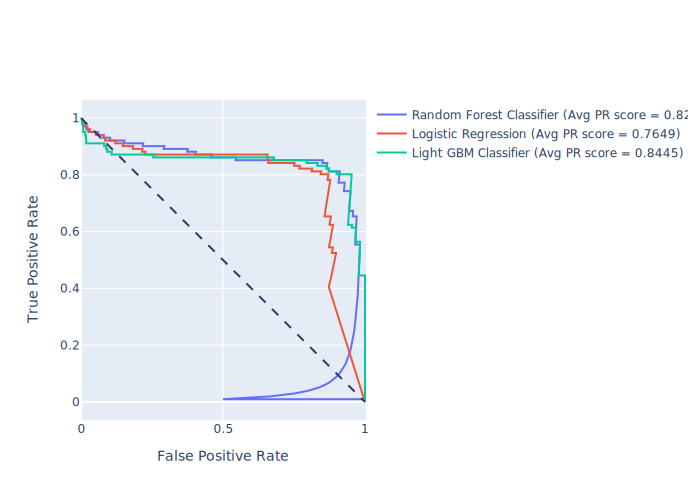

In [28]:
prec_recall_df = pd.concat([create_prec_recall_df(prec_logreg, recall_logreg, "Logistic Regression"),
                            create_prec_recall_df(prec_rf, recall_rf, "Random Forest Classifier"),
                            create_prec_recall_df(prec_lgbm, recall_lgbm, "Light GBM Classifier")])

avg_prec_dict = {"Logistic Regression" : avg_prec_logreg,
                 "Random Forest Classifier" : avg_prec_rf,
                 "Light GBM Classifier" : avg_prec_lgbm}

#- plot the precision-recall curve
precision_recall(prec_recall_df, avg_prec_dict)